# Over-sampling Method Comparison
Machine Learning with Imbalanced Data - Course

We will determine if the different over-sampling algorithms discussed in this section improve the performance of Random Forests on different datasets with imbalanced classes.

In [1]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from imblearn.datasets import fetch_datasets
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

In [2]:
oversampler_dict = {
    'smote': SMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5,
    ),

    'border1': BorderlineSMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        ),

    'svm': SVMSMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5,
        m_neighbors=10,
        svm_estimator=SVC(kernel='linear')),

    'smenn': SMOTEENN(
        sampling_strategy='auto',
        random_state=0,
        smote=SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=5),
        enn=EditedNearestNeighbours(
            sampling_strategy='auto', n_neighbors=3, kind_sel='all'),
        ),

    'smtomek': SMOTETomek(
        sampling_strategy='auto',
        random_state=0,
        smote=SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=5),
        tomek=TomekLinks(sampling_strategy='all'),
        ),
}

In [3]:
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [4]:
# print class imbalance

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [5]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=2, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

    return roc_auc_score(y_test, pred[:, 1])

In [6]:
# to save the results
results_dict = {}
shapes_dict = {}

for dataset in datasets_ls:
    
    results_dict[dataset] = {}
    shapes_dict[dataset] = {}
    
    print(dataset)
    
    # load dataset
    data = fetch_datasets()[dataset]
    
    # separate train and test
    X_train, X_test, y_train, y_test = train_test_split(
    data.data,  
    data.target, 
    test_size=0.3,
    random_state=0)
    
    # as some oversampling techniques use KNN
    # we set variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    
    # store results
    results_dict[dataset]['full_data'] = roc
    shapes_dict[dataset]['full_data'] = len(X_train)
    
    print()
    
    for oversampler in oversampler_dict.keys():
        
        print(oversampler)
        
        # resample
        X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
        
        # evaluate performance
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        
        #store results
        results_dict[dataset][oversampler] = roc
        shapes_dict[dataset][oversampler] = len(X_resampled)
        print()
        
    print()

car_eval_34
Train set
Random Forests roc-auc: 0.9581261802905924
Test set
Random Forests roc-auc: 0.9440504133074803

smote
Train set
Random Forests roc-auc: 0.9892067644300562
Test set
Random Forests roc-auc: 0.982268598836616

border1
Train set
Random Forests roc-auc: 0.9892200125897663
Test set
Random Forests roc-auc: 0.9863506480253086

svm
Train set
Random Forests roc-auc: 0.9898226031268869
Test set
Random Forests roc-auc: 0.9834677007857945

smenn
Train set
Random Forests roc-auc: 0.9891561805475264
Test set
Random Forests roc-auc: 0.9806868047759976

smtomek
Train set
Random Forests roc-auc: 0.9892067644300562
Test set
Random Forests roc-auc: 0.982268598836616


ecoli
Train set
Random Forests roc-auc: 0.9716599190283401
Test set
Random Forests roc-auc: 0.9408212560386474

smote
Train set
Random Forests roc-auc: 0.9773356837068748
Test set
Random Forests roc-auc: 0.9601449275362319

border1
Train set
Random Forests roc-auc: 0.9769121586044276
Test set
Random Forests roc-auc: 0.9

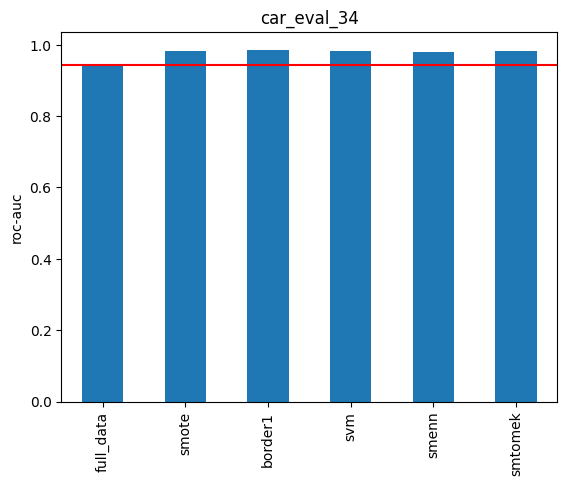

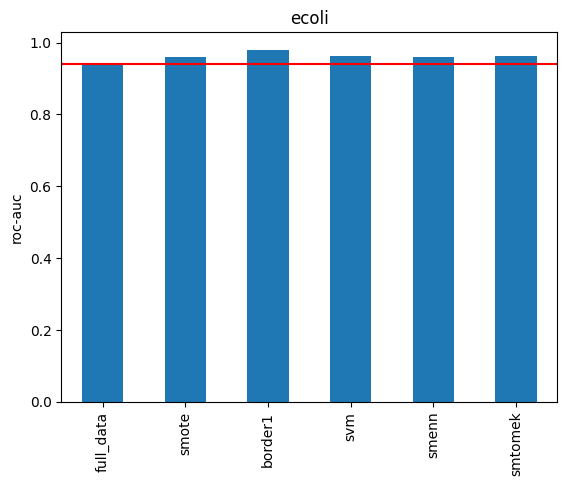

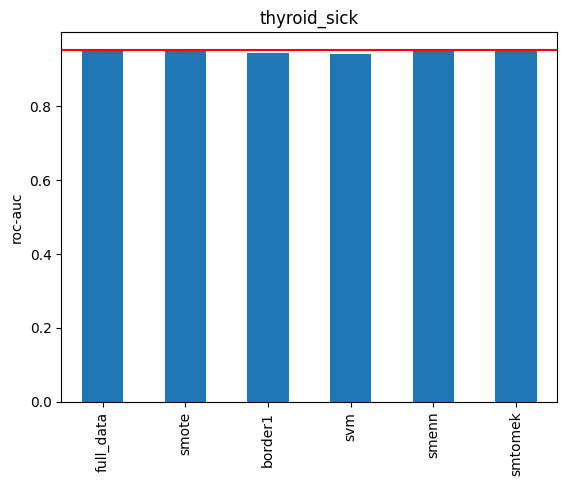

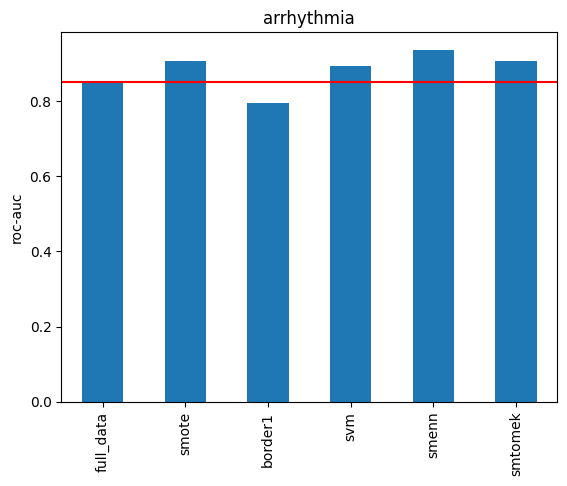

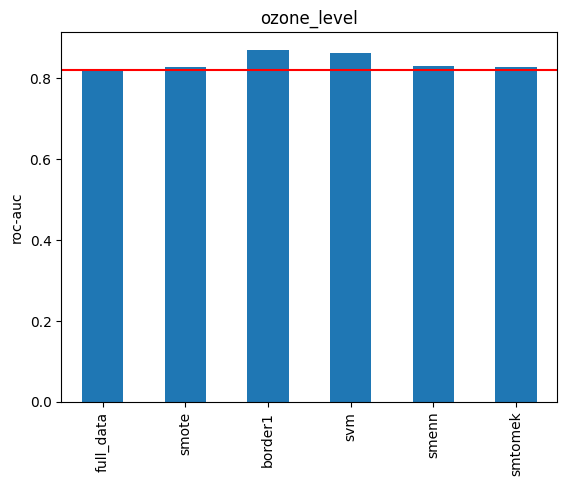

In [7]:
for dataset in datasets_ls:
    
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
#     plt.ylim(0.55, 0.9)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

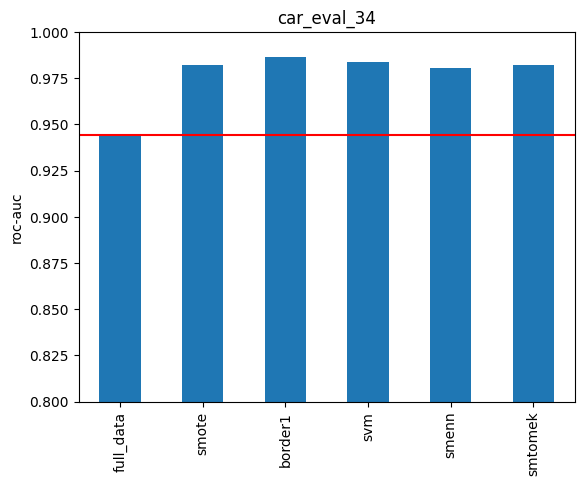

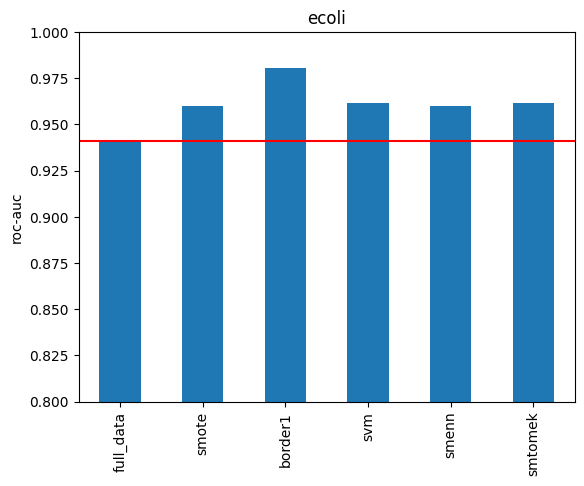

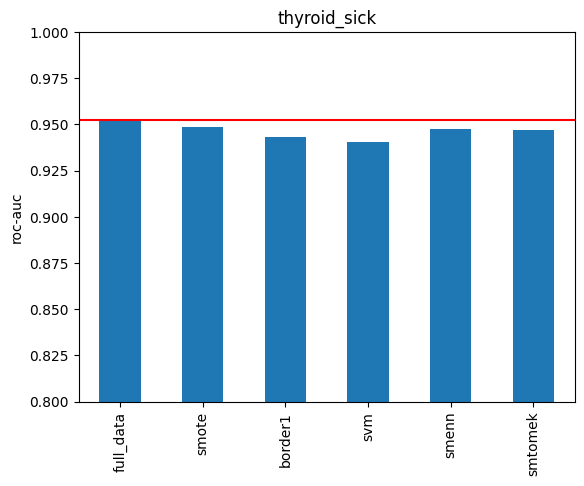

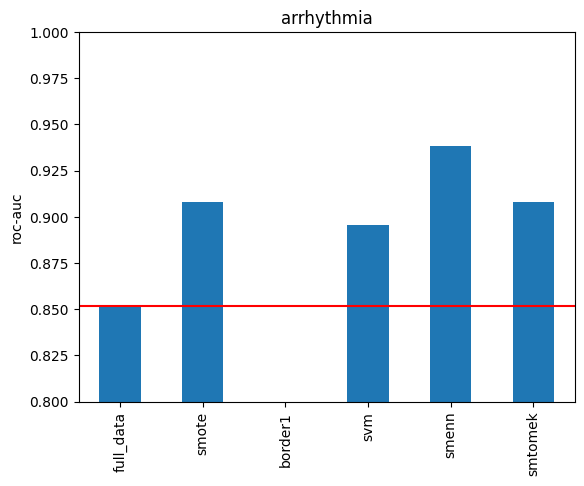

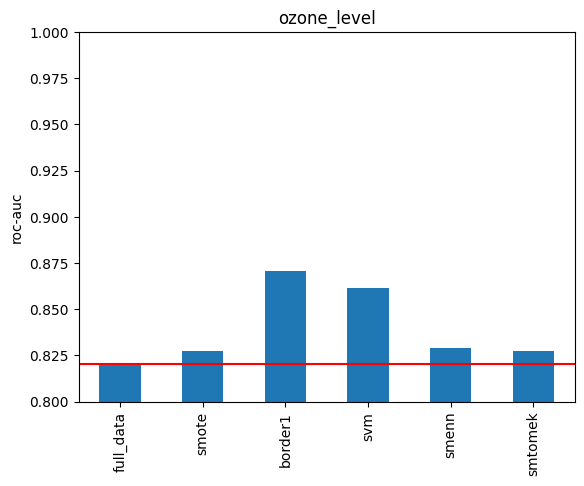

In [8]:
for dataset in datasets_ls:
    
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    plt.ylim(0.8, 1)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

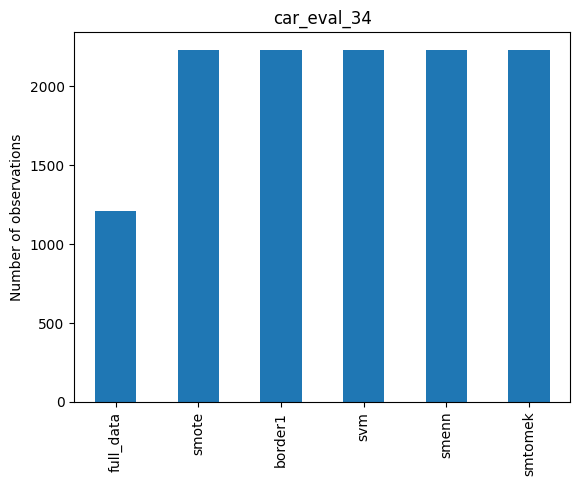

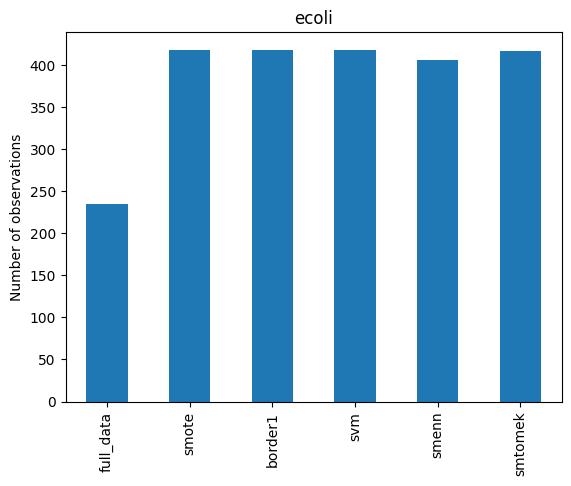

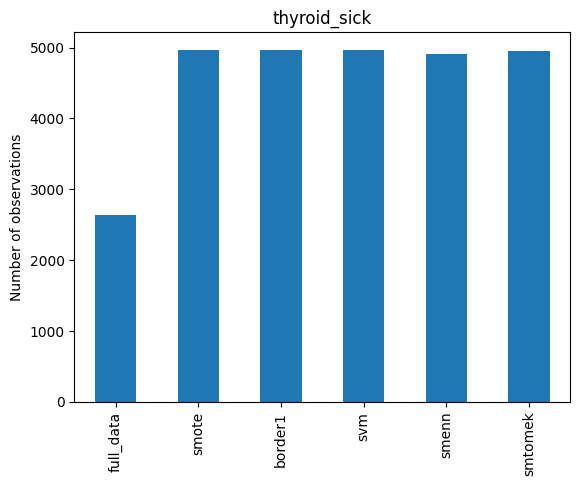

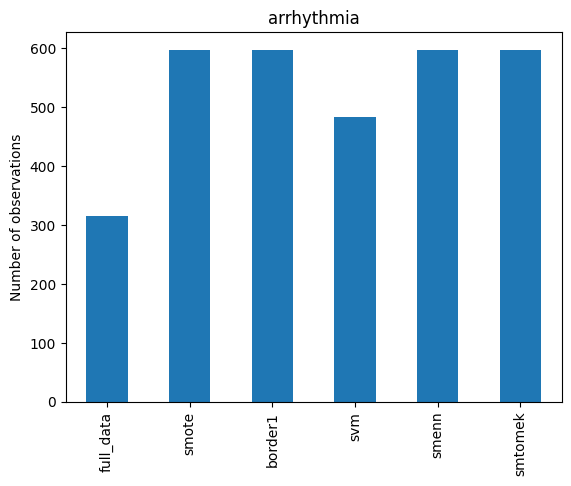

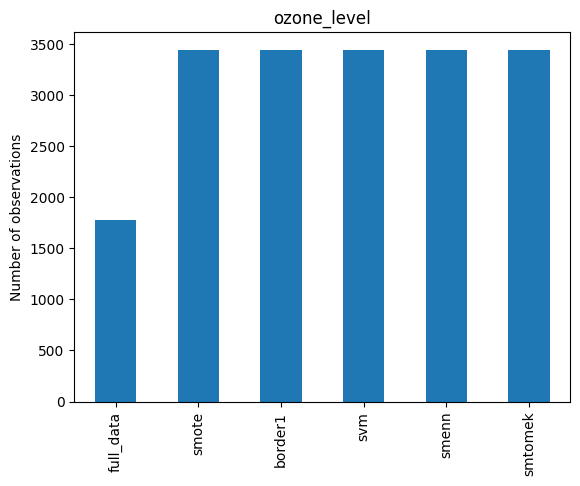

In [9]:
for dataset in datasets_ls:
    
    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('Number of observations')
    plt.show()